In [ ]:
import matplotlib.pyplot as plt #모형 학습시 accuracy와 loss를 저장하기 위한 라이브러리입니다.
%matplotlib inline
import os
import pandas as pd
from keras.preprocessing import image
from tensorflow.keras.utils import save_img
import json
from glob import glob
import cv2
from PIL import Image

"""전처리를 위한 라이브러리"""
import os
import pandas as pd
import numpy as np

In [ ]:
path='/mnt/hackerton/dataset/Dataset/'
os.listdir( path + 'Eye/Train/' ) # 결막염, 안검내반증, 유루증, 백내장

In [ ]:
# sample
train_path = path + 'Eye/Train/Epiphora/'
val_path = path + 'Eye/Validation/Epiphora/'

In [ ]:
#Eye (Train_data)
t_co0_paths=glob(path + 'Eye/Train/Conjunctivitis/0/*.png' ) # 결막염
t_co1_paths=glob(path + 'Eye/Train/Conjunctivitis/1/*.jpg' )
l_co0_paths=glob(path + 'Eye/Validation/Conjunctivitis/0/*.png' )
l_co1_paths=glob(path + 'Eye/Validation/Conjunctivitis/1/*.jpg' )
t_en0_paths=glob(path + 'Eye/Train/Entropion/0/*.png' ) # 안검내반증
t_en1_paths=glob(path + 'Eye/Train/Entropion/1/*.jpg' )
l_en0_paths=glob(path + 'Eye/Validation/Entropion/0/*.png' )
l_en1_paths=glob(path + 'Eye/Validation/Entropion/1/*.jpg' )
t_ep0_paths=glob(path + 'Eye/Train/Epiphora/0/*.png' )  # 유루증
t_ep1_paths=glob(path + 'Eye/Train/Epiphora/1/*.jpg' )
l_ep0_paths=glob(path + 'Eye/Validation/Epiphora/0/*.png' )
l_ep1_paths=glob(path + 'Eye/Validation/Epiphora/1/*.jpg' )
t_ca0_paths=glob(path + 'Eye/Train/Cataract/0/*.png' )  # 백내장
t_ca1_paths=glob(path + 'Eye/Train/Cataract/1/*.jpg' )
t_ca2_paths=glob(path + 'Eye/Train/Cataract/2/*.jpg' )
l_ca0_paths=glob(path + 'Eye/Validation/Cataract/0/*.png' )
l_ca1_paths=glob(path + 'Eye/Validation/Cataract/1/*.jpg' )
l_ca2_paths=glob(path + 'Eye/Validation/Cataract/2/*.jpg' )
eye_list=[[t_co0_paths,t_co1_paths,l_co0_paths,l_co1_paths],
          [t_en0_paths,t_en1_paths,l_en0_paths,l_en1_paths],
          [t_ep0_paths,t_ep1_paths,l_ep0_paths,l_ep1_paths],
          [t_ca0_paths,t_ca1_paths,t_ca2_paths,l_ca0_paths,l_ca1_paths,l_ca2_paths]]

In [ ]:
for i in range(len(eye_list)): #정렬
    for j in range(len(eye_list[i])):
        eye_list[i][j].sort()

In [ ]:
os.path.basename(eye_list[0][1][0][:-4])

In [ ]:
# 원본
img=image.load_img(eye_list[0][1][10], target_size=(250, 250))
img

In [ ]:
# 원본 라벨링
with open(eye_list[0][3][0]) as f:
    data=json.load(f)
data

### DATA 정제

In [ ]:
# 결막염 이미지 정제
def Conjunctivitis_p(image, size):
    img=cv2.imread(image, cv2.IMREAD_COLOR)
    src_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red = cv2.inRange(src_hsv, (0,0,0), (7,255,255))
    upper_red = cv2.inRange(src_hsv, (170,0,0), (180,255,255))
    added_red = cv2.addWeighted(lower_red, 1.0, upper_red, 1.0, 0.0) 
    src_hsv = cv2.cvtColor(src_hsv, cv2.COLOR_HSV2RGB)
    img_result = cv2.bitwise_and(src_hsv, src_hsv, mask = added_red)
    img_result = cv2.resize(img_result, dsize=size, interpolation=cv2.INTER_AREA)
    #to_img=Image.fromarray(img_result)
    
    return img_result

In [ ]:
# 백내장 이미지 정제
def Cataract_p(image, size):
    img=cv2.imread(image, cv2.IMREAD_COLOR)
    src_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = cv2.inRange(src_hsv, (30,0,0), (110,255,255))
    upper_blue = cv2.inRange(src_hsv, (115,0,0), (135,255,255))
    added_blue = cv2.addWeighted(lower_blue, 1.0, upper_blue, 1.0, 0.0) 
    img_result = cv2.bitwise_and(src_hsv, src_hsv, mask = added_blue)
    img_result = cv2.resize(img_result, dsize=size, interpolation=cv2.INTER_AREA)
    #img_result=Image.fromarray(img_result)
    
    return img_result

In [ ]:
# 유루증 이미지 정제
def Epiphora_p(image, size):
    img=cv2.imread(image, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(src, (0, 0), 1)
    ret, dst = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edge1 = cv2.Canny(dst, 50, 200)
    img_result = cv2.resize(edge1, dsize=size, interpolation=cv2.INTER_AREA)
    #img_result=Image.fromarray(edge1)
    
    return img_result

In [ ]:
# 안검내반증 이미지 정제
def Entropion_p(image, size):
    img=cv2.imread(image, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(src, (0, 0), 1)
    ret,bimage = cv2.threshold(blur,50,255,cv2.THRESH_BINARY_INV)
    bimage = cv2.dilate(bimage,None)

    mode = cv2.RETR_EXTERNAL
    method = cv2.CHAIN_APPROX_SIMPLE
    contours,hierarchy = cv2.findContours(bimage,mode,method)

    maxLength=0
    k=0
    for i,cnt in enumerate(contours):
        perimeter = cv2.arcLength(cnt,closed=True)
        if perimeter > maxLength:
            maxLength = perimeter
            k=i
      
    cnt = contours[k]
    
    dst = np.zeros_like(blur)
    cv2.drawContours(dst,[cnt],0,(255,0,0),50)
    masked = cv2.bitwise_and(blur, dst)
    masked = cv2.resize(masked, dsize=size, interpolation=cv2.INTER_AREA)
    #img=Image.fromarray(masked)
    return masked

In [ ]:
def validation_f(path_list, size):
    for path in path_list:
        name=os.path.basename(path[:-4])
        fext=os.path.basename(path[-4:])
        img=image.load_img(path, target_size=size)
        img=image.img_to_array(img)
        if not os.path.exists(save_folder+name+fext):
            save_img(save_folder+name+fext, img)

In [ ]:
def make_data(path_list, size, func):
    for path in path_list:
        name=os.path.basename(path[:-4])
        fext=os.path.basename(path[-4:])
        img=image.load_img(path, target_size=size)
        img=image.img_to_array(img)
        if not os.path.exists(save_folder+name+fext):
            save_img(save_folder+name+fext, img)
        new_img=func(path, size)
        if not os.path.exists(save_folder+name+'mask'+fext):
            cv2.imwrite(save_folder+name+'mask'+fext, new_img)

In [ ]:
def make_data2(path_list, size, func):
    for path in path_list:
        name=os.path.basename(path[:-4])
        fext=os.path.basename(path[-4:])
        new_img=func(path, size)
        if not os.path.exists(save_folder+name+'mask'+fext):
            cv2.imwrite(save_folder+name+'mask'+fext, new_img)

In [ ]:
# 결막염 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[0] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[0][0],size, Conjunctivitis_p) # data 만들기

In [ ]:
# 결막염 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[0] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[0][1],size, Conjunctivitis_p) # data 만들기

In [ ]:
# 결막염 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[0] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[0][2],size, Conjunctivitis_p)

In [ ]:
# 결막염 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[0] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[0][2],size)

In [ ]:
# 결막염 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[0] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[0][3],size, Conjunctivitis_p)

In [ ]:
# 결막염 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[0] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[0][3],size)

In [ ]:
# 백내장 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[3] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[3][0],size, Cataract_p) # data 만들기

In [ ]:
# 백내장 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[3] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[3][1],size, Cataract_p) # data 만들기

In [ ]:
# 백내장 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[3] + '/2/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[3][2],size, Cataract_p) # data 만들기

In [ ]:
# 백내장 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[3] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[3][3],size)

In [ ]:
# 백내장 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[3] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[3][4],size, Cataract_p)

In [ ]:
# 백내장 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[3] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[3][4],size)

In [ ]:
# 백내장 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[3] + '/2/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[3][5],size, Cataract_p)

In [ ]:
# 백내장 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[3] + '/2/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[3][5],size)

In [ ]:
# 유루증 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[2] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[2][0],size, Epiphora_p) # data 만들기

In [ ]:
# 유루증 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[2] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[2][1],size, Epiphora_p) # data 만들기

In [ ]:
# 유루증 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[2] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[2][2],size, Epiphora_p)

In [ ]:
# 유루증 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[2] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[2][2],size)

In [ ]:
# 유루증 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[2] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[2][3],size, Epiphora_p)

In [ ]:
# 유루증 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[2] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[2][3],size)

In [ ]:
# 안검내반증 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[1] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[1][0],size, Entropion_p) # data 만들기

In [ ]:
# 안검내반증 data 생성 (마스킹+원본)
save_folder = '/home/hackerton/Data/Eye2/Train/' + eye_name[1] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data(eye_list[1][1],size, Entropion_p) 

In [ ]:
# 안검내반증 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[1] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[1][2],size, Entropion_p)

In [ ]:
# 안검내반증 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[1] + '/0/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[1][2],size)

In [ ]:
# 안검내반증 valid 옮기기 (마스킹)
save_folder = '/home/hackerton/Data/Eye/Validation/' + eye_name[1] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
make_data2(eye_list[1][3],size, Entropion_p)

In [ ]:
# 안검내반증 valid 옮기기 (원본)
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[1] + '/1/'
size=(224,224)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
validation_f(eye_list[1][3],size)

In [ ]:
# 확인용
save_folder = '/home/hackerton/Data/Eye2/Validation/' + eye_name[0] + '/0/'
os.listdir( save_folder )

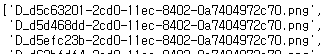

In [ ]:
img=image.load_img(save_folder+'D_d8ea09c1-2cd0-11ec-8402-0a7404972c70.png')
img

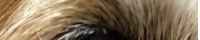

In [ ]:
# 리눅스 환경 번외

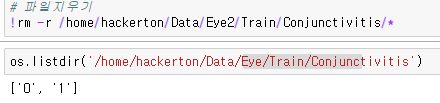